# Imports

In [1]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn

from PIL import Image
import os
from contextlib import redirect_stdout
import ssl

import time

import matplotlib.pyplot as plt

ssl._create_default_https_context = ssl._create_unverified_context

# Constants

In [2]:
dataset_path = '/kaggle/input/final-version/Stage 1/Stage 1'

# Dataset & Preprocessing

In [3]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

if os.path.exists(dataset_path + '.DS_Store'):
        os.remove(dataset_path + '.DS_Store')

dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

In [4]:
total_size = len(dataset)

train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Loading & Modifying ResNet-101 Model

In [5]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)

with redirect_stdout(None):
    model.eval()

num_features = model.fc.in_features
num_classes = 2

new_fc_layers = [
    torch.nn.Linear(num_features, 512),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(256, num_classes)
]
model.fc = torch.nn.Sequential(*new_fc_layers)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 150MB/s]  


# Hyperparameters

In [6]:
num_epochs = 100
batch_size = 16
patience = 20
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

# Training

In [7]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
model = model.to('cuda')

best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
sensitivities = []
specificities = []

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted_train = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()
        
        true_positives += ((predicted_train == 1) & (labels == 1)).sum().item()
        true_negatives += ((predicted_train == 0) & (labels == 0)).sum().item()
        false_positives += ((predicted_train == 1) & (labels == 0)).sum().item()
        false_negatives += ((predicted_train == 0) & (labels == 1)).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    
    sensitivity = true_positives / (true_positives + false_negatives)
    specificity = true_negatives / (true_negatives + false_positives)
    
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted_val = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    
    flag = False
    if val_loss < best_val_loss:
        flag = True
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            early_stop = True
            
    end_time = time.time()
    epoch_time = end_time - start_time

    if flag:
        print(f'Epoch [{epoch+1}/{num_epochs}]: {epoch_time:.2f}s | Saved Model\nTrain Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}%\nValidation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.2f}%')
    else:
        print(f'Epoch [{epoch+1}/{num_epochs}]: {epoch_time:.2f}s\nTrain Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}%\nValidation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.2f}%')
    print('===================================================================================================')
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    
    if early_stop:
        print('========================Early Stopped========================')
        break

Epoch [1/100]: 132.56s | Saved Model
Train Loss: 0.1399 | Train Accuracy: 95.12%
Validation Loss: 0.0882 | Validation Accuracy: 96.83%
Epoch [2/100]: 105.49s | Saved Model
Train Loss: 0.0635 | Train Accuracy: 97.75%
Validation Loss: 0.0579 | Validation Accuracy: 98.17%
Epoch [3/100]: 104.79s | Saved Model
Train Loss: 0.0396 | Train Accuracy: 98.83%
Validation Loss: 0.0318 | Validation Accuracy: 99.03%
Epoch [4/100]: 104.13s
Train Loss: 0.0246 | Train Accuracy: 99.24%
Validation Loss: 0.0726 | Validation Accuracy: 97.93%
Epoch [5/100]: 106.03s | Saved Model
Train Loss: 0.0176 | Train Accuracy: 99.41%
Validation Loss: 0.0279 | Validation Accuracy: 99.15%
Epoch [6/100]: 105.19s
Train Loss: 0.0174 | Train Accuracy: 99.38%
Validation Loss: 0.0882 | Validation Accuracy: 97.69%
Epoch [7/100]: 104.28s
Train Loss: 0.0202 | Train Accuracy: 99.27%
Validation Loss: 0.0397 | Validation Accuracy: 98.29%
Epoch [8/100]: 104.39s
Train Loss: 0.0331 | Train Accuracy: 99.22%
Validation Loss: 0.0590 | Vali

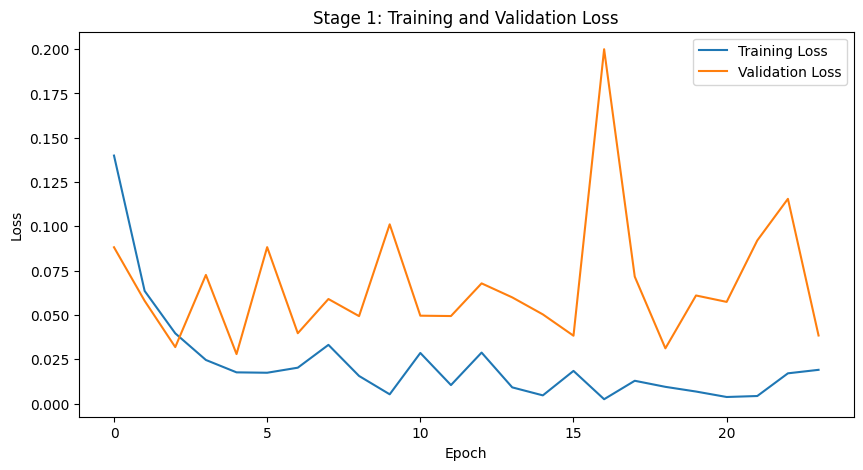

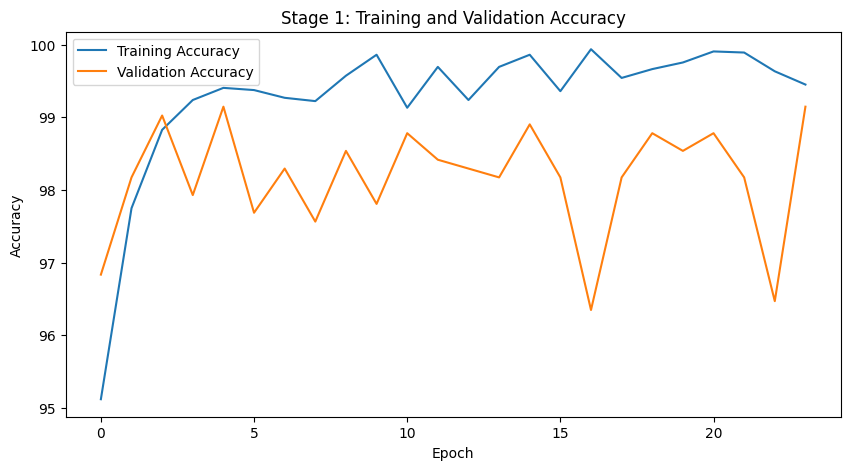

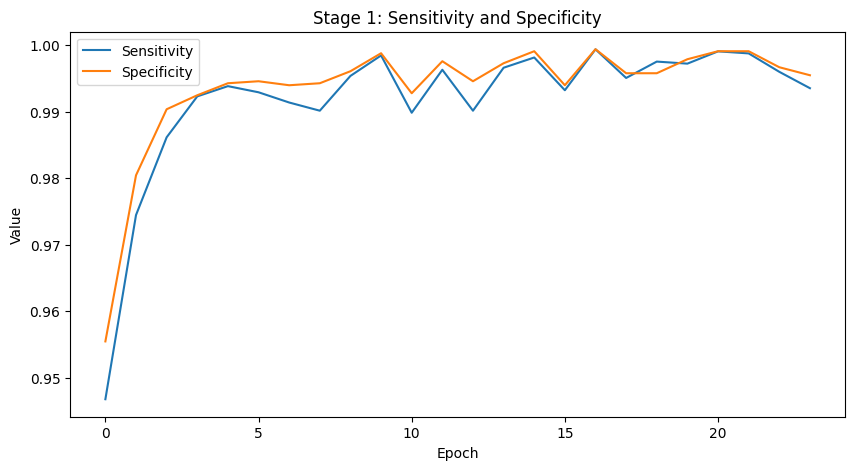

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Stage 1: Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Stage 1: Training and Validation Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(sensitivities, label='Sensitivity')
plt.plot(specificities, label='Specificity')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Stage 1: Sensitivity and Specificity')
plt.legend()
plt.show()

In [10]:
model.load_state_dict(torch.load('best_model.pth'))

model.eval()
test_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = 100 * correct / total

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.0095, Test Accuracy: 99.64%
